In [2]:
import math
import d2l
from mxnet import nd, autograd
from mxnet.gluon import nn

In [3]:
class MultiHeadAttention(nn.Block):
    def __init__(self, units, num_heads, dropout, **kwargs):  # units = d_o
        super(MultiHeadAttention, self).__init__(**kwargs)
        assert units % num_heads == 0
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.Dense(units, use_bias=False, flatten=False)
        self.W_k = nn.Dense(units, use_bias=False, flatten=False)
        self.W_v = nn.Dense(units, use_bias=False, flatten=False)

    # query, key, and value shape: (batch_size, num_items, dim)
    # valid_length shape is either (bathc_size, ) or (batch_size, num_items)
    def forward(self, query, key, value, valid_length):
        # Project and transpose from (batch_size, num_items, units) to
        # (batch_size * num_heads, num_items, p), where units = p * num_heads.
        query, key, value = [transpose_qkv(X, self.num_heads) for X in (
            self.W_q(query), self.W_k(key), self.W_v(value))]
        if valid_length is not None:
            # Copy valid_length by num_heads times
            if valid_length.ndim == 1:
                valid_length = valid_length.tile(self.num_heads)
            else:
                valid_length = valid_length.tile((self.num_heads, 1))
        output = self.attention(query, key, value, valid_length)
        # Transpose from (batch_size * num_heads, num_items, p) back to
        # (batch_size, num_items, units)
        return transpose_output(output, self.num_heads)

In [4]:
def transpose_qkv(X, num_heads):
    # Shape after reshape: (batch_size, num_items, num_heads, p)
    # 0 means copying the shape element, -1 means inferring its value
    X = X.reshape((0, 0, num_heads, -1))
    # Swap the num_items and the num_heads dimensions
    X = X.transpose((0, 2, 1, 3))
    # Merge the first two dimensions. Use reverse=True to infer
    # shape from right to left
    return X.reshape((-1, 0, 0), reverse=True)

def transpose_output(X, num_heads):
    # A reversed version of transpose_qkv
    X = X.reshape((-1, num_heads, 0, 0), reverse=True)
    X = X.transpose((0, 2, 1, 3))
    return X.reshape((0, 0, -1))

In [5]:
cell = MultiHeadAttention(100, 10, 0.5)
cell.initialize()
X = nd.ones((2, 4, 5))
valid_length = nd.array([2,3])
cell(X, X, X, valid_length).shape

(2, 4, 100)

In [6]:
class PositionWiseFFN(nn.Block):
    def __init__(self, units, hidden_size, **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.ffn_1 = nn.Dense(hidden_size, flatten=False, activation='relu')
        self.ffn_2 = nn.Dense(units, flatten=False)

    def forward(self, X):
        return self.ffn_2(self.ffn_1(X))

In [7]:
ffn = PositionWiseFFN(4, 8)
ffn.initialize()
ffn(nd.ones((2, 3, 4)))[0]



[[ 0.00752072  0.00865059  0.01013744 -0.00906538]
 [ 0.00752072  0.00865059  0.01013744 -0.00906538]
 [ 0.00752072  0.00865059  0.01013744 -0.00906538]]
<NDArray 3x4 @cpu(0)>

In [8]:
layer = nn.LayerNorm()
layer.initialize()
batch = nn.BatchNorm()
batch.initialize()
X = nd.array([[1,2],[2,3]])
# compute mean and variance from X in the training mode.
with autograd.record():
    print('layer norm:',layer(X), '\nbatch norm:', batch(X))

layer norm: 
[[-0.99998  0.99998]
 [-0.99998  0.99998]]
<NDArray 2x2 @cpu(0)> 
batch norm: 
[[-0.99998 -0.99998]
 [ 0.99998  0.99998]]
<NDArray 2x2 @cpu(0)>


In [9]:
class AddNorm(nn.Block):
    def __init__(self, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm()

    def forward(self, X, Y):
        return self.norm(self.dropout(Y) + X)

In [10]:
add_norm = AddNorm(0.5)
add_norm.initialize()
add_norm(nd.ones((2,3,4)), nd.ones((2,3,4))).shape

(2, 3, 4)

In [11]:
class PositionalEncoding(nn.Block):
    def __init__(self, units, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough P
        self.P = nd.zeros((1, max_len, units))
        X = nd.arange(0, max_len).reshape((-1,1)) / nd.power(
            10000, nd.arange(0, units, 2)/units)
        self.P[:, :, 0::2] = nd.sin(X)
        self.P[:, :, 1::2] = nd.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].as_in_context(X.context)
        return self.dropout(X)

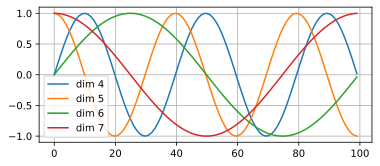

In [12]:
pe = PositionalEncoding(20, 0)
pe.initialize()
Y = pe(nd.zeros((1, 100, 20 )))
d2l.plot(nd.arange(100), Y[0, :,4:8].T, figsize=(6, 2.5),
        legend=["dim %d"%p for p in [4,5,6,7]])